## Import library

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from skimage.feature import graycomatrix, graycoprops
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn


## Import Env File

In [2]:
from dotenv import load_dotenv  

load_dotenv()
datasets_path = os.getenv('AUGMENTED_SMALL_PATH_JOGJA_PEKALONGAN')
models_path = os.getenv('MODELS_PATH')

In [3]:
os.listdir(datasets_path)

['jogja', 'pekalongan']

## Device Configuration

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Parameters

In [5]:
num_classes = 2
batch_size = 16
test_split_ratio = 0.2
val_split_ratio = 0.2

## Data Preprocessing

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Custom Dataset With GLCM Features

In [7]:
from torch.utils.data import Dataset
import numpy as np
import cv2
import torch
from skimage.feature import graycomatrix, graycoprops

class GLCMCNNHybridDataset(Dataset):
    def __init__(self, image_folder_dataset, transform=None):
        self.image_folder_dataset = image_folder_dataset
        self.transform = transform
        # Simpan fitur GLCM dan label
        self.glcm_features = []
        self.labels = []

        print("🔄 Preprocessing GLCM features...")

        for idx in range(len(image_folder_dataset)):
            image, label = image_folder_dataset[idx]

            # Simpan label
            self.labels.append(label)

            # Transform dulu (pakai transform yg sama dengan training)
            if self.transform:
                image = self.transform(image)

            # Convert tensor (C, H, W) -> numpy image (H, W, C)
            image_np = image.permute(1, 2, 0).cpu().numpy()
            image_np = (image_np * 255).astype(np.uint8)

            # Ekstrak GLCM
            gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
            distances = [1, 2, 3]
            angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
            glcm = graycomatrix(gray, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
            props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
            features = []
            for prop in props:
                values = graycoprops(glcm, prop)
                features.extend(values.flatten())
            features = np.array(features, dtype=np.float32)

            # Normalisasi fitur (z-score)
            features = (features - features.mean()) / (features.std() + 1e-8)
            self.glcm_features.append(features)

        # Konversi list ke tensor
        self.glcm_features = torch.tensor(np.array(self.glcm_features), dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

        print("✅ GLCM features extracted and cached.")

    def __len__(self):
        return len(self.image_folder_dataset)

    def __getitem__(self, index):
        image, _ = self.image_folder_dataset[index]  # label diambil dari self.labels

        if self.transform:
            image = self.transform(image)

        glcm_feature = self.glcm_features[index]
        label = self.labels[index]

        return image, glcm_feature, label

## Data Loaders

In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Buat dataset dasar
base_dataset = datasets.ImageFolder(root=datasets_path)
hybrid_dataset = GLCMCNNHybridDataset(base_dataset, transform=transform)

# Ambil semua label
targets = base_dataset.targets
indices = list(range(len(base_dataset)))

# Pertama: Bagi data menjadi train+val dan test
trainval_indices, test_indices = train_test_split(
    indices,
    test_size=test_split_ratio,
    stratify=targets,
    random_state=42
)

# Ambil label untuk data trainval
trainval_targets = [targets[i] for i in trainval_indices]

# Kedua: Bagi trainval menjadi train dan val
train_indices, val_indices = train_test_split(
    trainval_indices,
    test_size=val_split_ratio,
    stratify=trainval_targets,
    random_state=42
)

# Buat subset dataset-nya
train_dataset = Subset(hybrid_dataset, train_indices)
val_dataset = Subset(hybrid_dataset, val_indices)
test_dataset = Subset(hybrid_dataset, test_indices)

# DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

🔄 Preprocessing GLCM features...
✅ GLCM features extracted and cached.


In [10]:
# Cek dimensi glcm_features
for images, glcm_features, labels in train_loader:
    print("Shape GLCM Features:", glcm_features.shape)
    break

Shape GLCM Features: torch.Size([16, 60])


In [11]:
from collections import Counter

print("Distribusi kelas (train):", Counter([base_dataset.targets[i] for i in train_indices]))
print("Distribusi kelas (test):", Counter([base_dataset.targets[i] for i in test_indices]))
print("Distribusi kelas (val):", Counter([base_dataset.targets[i] for i in val_indices]))

Distribusi kelas (train): Counter({1: 246, 0: 245})
Distribusi kelas (test): Counter({0: 77, 1: 77})
Distribusi kelas (val): Counter({0: 62, 1: 61})


## Load Pre-Trained Model (EfficientNet)

In [12]:
# Load EfficientNet-B0
weights = EfficientNet_B0_Weights.DEFAULT
cnn_model = efficientnet_b0(weights=weights)
cnn_feature_size = cnn_model.classifier[1].in_features  # EfficientNet features

# Replace classification layer to get features
cnn_model.classifier = nn.Identity()
cnn_model = cnn_model.to(device)

In [13]:
print(cnn_feature_size)

1280


## Hybrid Model

In [14]:
class PararelModel(nn.Module):
    def __init__(self, cnn_model, glcm_feature_size, cnn_feature_size, num_classes):
        super(PararelModel, self).__init__()
        self.cnn_model = cnn_model
        self.fc1 = nn.Linear(glcm_feature_size + cnn_feature_size, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, image, glcm_features):
        cnn_features = self.cnn_model(image)
        combined_features = torch.cat((glcm_features, cnn_features), dim=1)
        x = self.fc1(combined_features)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Simplified Hybrid Model

In [15]:
class SimpleParallelModel(nn.Module):
    def __init__(self, cnn_model, glcm_feature_size, cnn_feature_size, num_classes):
        super(SimpleParallelModel, self).__init__()
        self.cnn_model = cnn_model
        self.fc1 = nn.Linear(glcm_feature_size + cnn_feature_size, 256)  # Menurunkan dimensi
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)  # Langsung ke output class

    def forward(self, image, glcm_features):
        cnn_features = self.cnn_model(image)
        combined_features = torch.cat((glcm_features, cnn_features), dim=1)
        x = self.fc1(combined_features)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Initialize Hybrid Model

In [18]:
glcm_feature_size = 60  # Number of GLCM features
# model = PararelModel(cnn_model, glcm_feature_size, cnn_feature_size, num_classes).to(device)
model = SimpleParallelModel(cnn_model, glcm_feature_size, cnn_feature_size, num_classes).to(device)

## Train The Model

In [19]:
num_epochs = 50
patience = 5  # jumlah epoch tanpa perbaikan sebelum berhenti
best_loss = float('inf')
epochs_no_improve = 0

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0015
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.5, patience=2, verbose=True)

def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, glcm_features, labels in data_loader:
            images, glcm_features, labels = images.to(device), glcm_features.to(device), labels.to(device)
            outputs = model(images, glcm_features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training loop dengan early stopping
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, glcm_features, labels in train_loader:
        images, glcm_features, labels = images.to(device), glcm_features.to(device), labels.to(device)

        # Forward pass
        outputs = model(images, glcm_features)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    val_acc = evaluate(model, test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Early Stopping Check
    if epoch_loss < best_loss - 1e-4:
        best_loss = epoch_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'temp/best_model_hybrid.pth')  # Simpan model terbaik
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"⛔ Early stopping triggered at epoch {epoch+1}")
        break


Epoch [1/50], Loss: 0.4252, Val Acc: 0.9935
Epoch [2/50], Loss: 0.1779, Val Acc: 0.9935
Epoch [3/50], Loss: 0.0916, Val Acc: 0.9805
Epoch [4/50], Loss: 0.1507, Val Acc: 0.9870
Epoch [5/50], Loss: 0.0761, Val Acc: 0.9805
Epoch [6/50], Loss: 0.0630, Val Acc: 0.9805
Epoch [7/50], Loss: 0.0615, Val Acc: 0.9870
Epoch [8/50], Loss: 0.0413, Val Acc: 0.9870
Epoch [9/50], Loss: 0.0644, Val Acc: 0.9870
Epoch [10/50], Loss: 0.0307, Val Acc: 0.9870
Epoch [11/50], Loss: 0.0253, Val Acc: 0.9870
Epoch [12/50], Loss: 0.0141, Val Acc: 0.9870
Epoch [13/50], Loss: 0.0313, Val Acc: 0.9870
Epoch [14/50], Loss: 0.0318, Val Acc: 0.9870
Epoch [15/50], Loss: 0.0124, Val Acc: 0.9870
Epoch [16/50], Loss: 0.0185, Val Acc: 0.9870
Epoch [17/50], Loss: 0.0077, Val Acc: 0.9870
Epoch [18/50], Loss: 0.0174, Val Acc: 0.9870
Epoch [19/50], Loss: 0.0224, Val Acc: 0.9935
Epoch [20/50], Loss: 0.0334, Val Acc: 0.9870
Epoch [21/50], Loss: 0.0204, Val Acc: 0.9870
Epoch [22/50], Loss: 0.0111, Val Acc: 0.9870
⛔ Early stopping tr

## Evaulation

Class 0:
  Precision: 0.9870
  Recall:    0.9870
  F1-Score:  0.9870
------------------------------
Class 1:
  Precision: 0.9870
  Recall:    0.9870
  F1-Score:  0.9870
------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        77
           1       0.99      0.99      0.99        77

    accuracy                           0.99       154
   macro avg       0.99      0.99      0.99       154
weighted avg       0.99      0.99      0.99       154



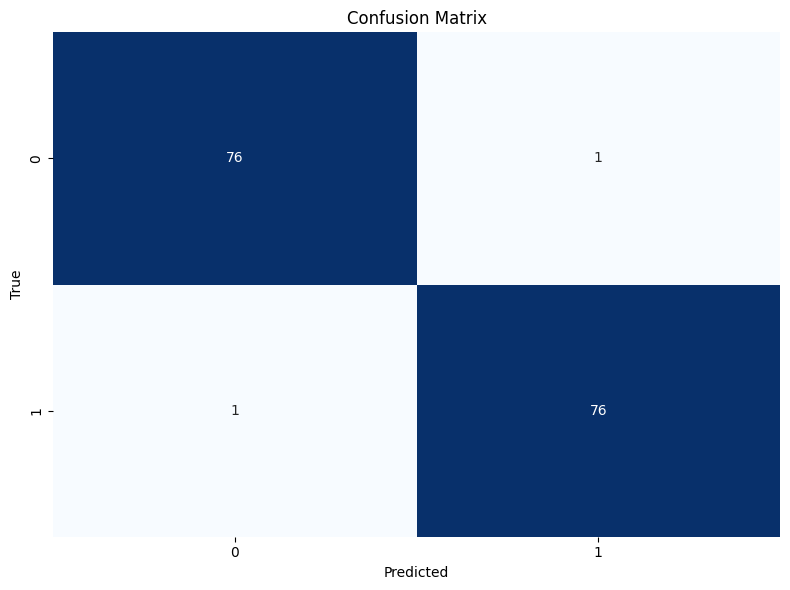

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, glcm_features, labels in test_loader:
        images, glcm_features, labels = images.to(device), glcm_features.to(device), labels.to(device)
        outputs = model(images, glcm_features)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Hitung precision, recall, f1 untuk setiap kelas
precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

# Tampilkan nilai precision, recall, dan f1-score per kelas
num_classes = len(set(all_labels))  # Jumlah kelas yang ada di dataset
for i in range(num_classes):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1-Score:  {f1[i]:.4f}")
    print("-" * 30)

# Tampilkan classification report
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


## Save The Model

In [21]:
torch.save(model.state_dict(), models_path+'/hybrid_glcm_cnn_modelv2.pth')